# Statistics on PCMA

## Load libraries

In [1]:
from pyspark import SparkContext
import pyspark.sql.types as typ
import re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sc = SparkContext.getOrCreate()

## Load PCMA files into RDD pcmas

In [6]:
pcmas = sc.wholeTextFiles("/Users/gverstra/Dev/Spark_tests/data/*/*/pcma/rack1.csv")

## Filter data and load it into RDD filteredpcmas

In [9]:
def extractInfoFromPCMAcontent(pcma):
    # search customerfromfilename and JIRA
    x = re.search(r"file:/Users/gverstra/Dev/Spark_tests/data/(.*)/(.*)/pcma/rack1.csv", pcma[0])
    if x != None:
        customerfromfilename = x[1]
        jira = x[2]
    else:
        customerfromfilename = ''
        jira = ''
    # search Version
    x = re.search(r"Version: ([\d.\-]+),", pcma[1])
    if x != None:
        pcmaversion = x[1]
    else:
        pcmaversion = ''
    # search Customer Name
    x = re.search(r",Customer Name,,,(.*),,,,,,,Enter Customer Name,,,,,,", pcma[1])
    if x != None:
        customername = x[1]
    else:
        customername = ''
    # search Number of OCC racks
    x = re.search(r",,,# of OCM racks including control plane,(\d+)", pcma[1])
    if x != None:
        numoccracks = int(x[1])
    else:
        numoccracks = ""
    # search Number of ExaCC racks
    x = re.search(r",,,# of ExaCM racks,(\d+)", pcma[1])
    if x != None:
        numexaccracks = int(x[1])
    else:
        numexaccracks = ""
    # search Port type on upstream router
    x = re.search(r",,,Port type on the upstream router\(s\),(.*),,,Port type:", pcma[1])
    if x != None:
        upstreamporttype = x[1]
    else:
        upstreamporttype = ""
    # search Number of ports on the upstream router
    x = re.search(r",,,Number of ports on the upstream router\(s\),(\d+)", pcma[1])
    if x != None:
        numupstreamports = int(x[1])
    else:
        numupstreamports = ""
    # search Port Channeling type
    x = re.search(r",Upstream router Port Config Type,,,(.*),,,,,,,\"If link", pcma[1])
    if x != None:
        portchanneling = x[1]
    else:
        portchanneling = ""
    return (customerfromfilename, jira, pcmaversion, customername, numoccracks, numexaccracks, upstreamporttype, numupstreamports, portchanneling)

filteredpcmas = pcmas.map(extractInfoFromPCMAcontent)
filteredpcmas.take(2)

[('ADVOCARE',
  'OCACS-517',
  '17.2.3-091117',
  'ADVOCARE',
  1,
  1,
  '10Gbps',
  4,
  '2 Link Aggregation Groups'),
 ('AIInversionesPaloAltoII',
  'OCACS-1057',
  '17.2.3-091117',
  'AI Inversiones Palo Alto II S.A.C.',
  1,
  0,
  '10Gbps',
  8,
  '2 Link Aggregation Groups')]

## Create a dataframe out of RDD filteredpcmas

In [5]:
schema = [
    ('customerfromfilename', typ.StringType()),
    ('jira', typ.StringType()),
    ('pcmaversion', typ.StringType()),
    ('customername', typ.StringType()),
    ('numoccracks', typ.IntegerType()),
    ('numexaccracks', typ.IntegerType()),
    ('upstreamporttype', typ.StringType()),
    ('numupstreamports', typ.IntegerType()),
    ('portchanneling', typ.StringType())
]
schema = typ.StructType([typ.StructField(e[0],e[1],True) for e in schema])

pcmadf = spark.createDataFrame(filteredpcmas, schema)
pcmadf.createOrReplaceTempView("pcmas")
pcmadf.count()

151

## Count PCMA by version

,pcmaversion,count
0,17.2.3-091117,111
1,17.2.3-081017,40


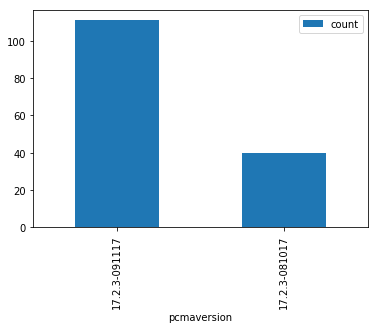

In [9]:
pdf = spark.sql("select pcmaversion,count(*) as count from pcmas group by pcmaversion").toPandas()
pdf.plot(kind='bar',x='pcmaversion')
pdf

## Count PCMA by Upstream port type

,upstreamporttype,count
0,10Gbps,127
1,40Gbps,24


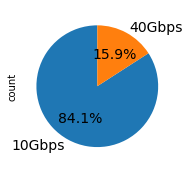

In [6]:
pdf = spark.sql("select upstreamporttype, count(*) as count from pcmas group by upstreamporttype").toPandas()
ax1 = plt.subplot(121, aspect='equal')
pdf.plot(kind='pie', y = 'count', ax=ax1, autopct='%1.1f%%', startangle=90, shadow=False, labels=pdf['upstreamporttype'], legend = False, fontsize=14)
pdf

,portchanneling,count
0,cross-chassis LAG,1
1,No link aggregation,72
2,2 Link Aggregation Groups,78


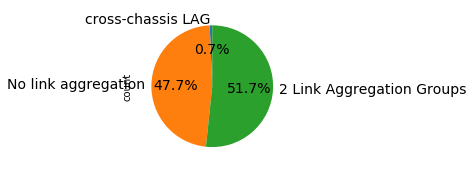

In [7]:
pdf = spark.sql("select portchanneling,count(*) as count from pcmas group by portchanneling").toPandas()
#pdf.plot(kind='bar',x='portchanneling')
ax1 = plt.subplot(121, aspect='equal')
pdf.plot(kind='pie', y = 'count', ax=ax1, autopct='%1.1f%%', startangle=90, shadow=False, labels=pdf['portchanneling'], legend = False, fontsize=14)
pdf

,numexaccracks,count
0,0,56
1,1,71
2,2,16
3,3,5
4,5,3


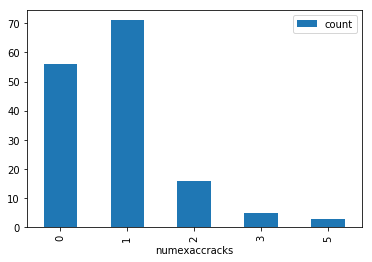

In [8]:
pdf = spark.sql("select numexaccracks,count(*) as count from pcmas group by numexaccracks order by numexaccracks").toPandas()
pdf.plot(kind='bar',x='numexaccracks')
pdf

In [7]:
pdf = spark.sql("select count(*) as NoLAG_count from pcmas where portchanneling like 'No link aggregation'").toPandas()
pdf

,NoLAG_count
0,72
